In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from collections import Counter
import time

import sys, os

sys.path.append(os.path.abspath("../../src"))

from SegLabel import SegLabel
from docplex.mp.model import Model
from dwave_utils import plot_qubo_matrix

from dimod import BinaryQuadraticModel
from tabu import TabuSampler

%load_ext lab_black

## Model

In [3]:
from SegmentationAndLabeling import SegmentationAndLabeling

# read the data
with open("cyclists_640_SegLabelData.pickle", "rb") as f:
    segLabel = pickle.load(f)

# detection positions
pos = {i: p for i, p in enumerate(segLabel.dets_pos)}

# beta_dc_d'c'u
B = segLabel.betas.copy()
B = np.nan_to_num(B, nan=0.0)
B_max = np.max(B)

print("B:")
print("  shape: ", np.shape(B))
print("  min/max: ", np.min(B), B_max)

# alpha_dc
A = segLabel.alphas.copy()
A = np.nan_to_num(A, nan=0.0)
A_max = B_max
A[A > A_max] = A_max  # truncate too high values

print("A:")
print("  shape: ", np.shape(A))
print("  min/max: ", np.min(A), np.max(A))
print("")

B:
  shape:  (146, 146, 14, 14)
  min/max:  -7.5 103.93
A:
  shape:  (146, 14)
  min/max:  -5.74 103.93



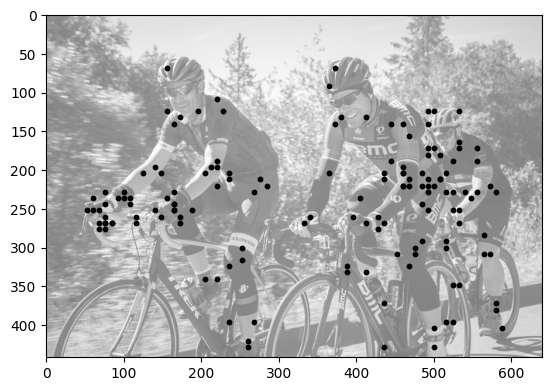

In [4]:
# Load image and convert to greyscale
img = Image.open("cyclists_640.jpg").convert("L")
img = ImageOps.colorize(img, black="grey", white="white")
plt.imshow(img)

for x, y in segLabel.dets_pos:
    plt.scatter(int(x), int(y), marker="o", c="k", s=10)

plt.show()

## S_max = 1

In [5]:
max_num_segments = 1
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
    pos=pos,
)

C = B_max

tic = time.perf_counter()
Q, offset = model.build_qubo(C=C, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")

Segmentation and Labeling Problem initialization:
  Number of nodes:  146
  Number of labels:  14
  Maximum number of segments:  1

>>>> QUBO setup: 4.9741 seconds
>>>> BQM setup: 2.9655 seconds


In [6]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  2044
Number of QUBO interactions:  2086740
Matrix sparsity:  0.9994223988551428
Energy offset: 15173.78


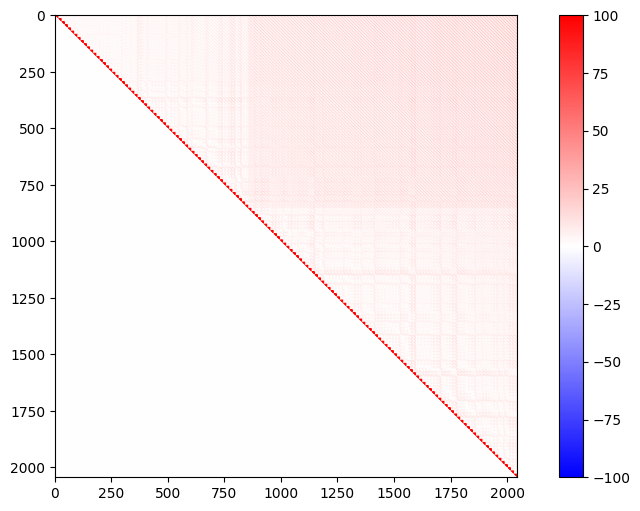

In [7]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [8]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=10_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  10.127565500006313


In [9]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  7969.629999999976
  max:  7969.629999999976
  median:  7969.629999999976
  mean:  7969.629999999976
  std:  0.0
Lowest solution:
  objective:  7969.629999999976
  probability:   1.0
  feasible:   False


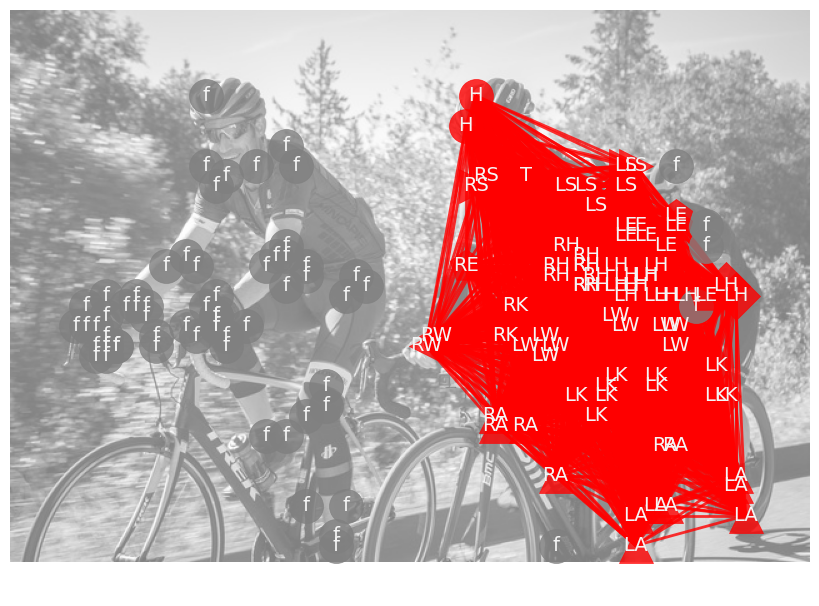

In [10]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)
ax = fig.add_axes(rect=(0, 0, 1, 1), frameon=False)

ax.imshow(img)

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=600,
    width=2,
    alpha=0.8,
)
plt.show()

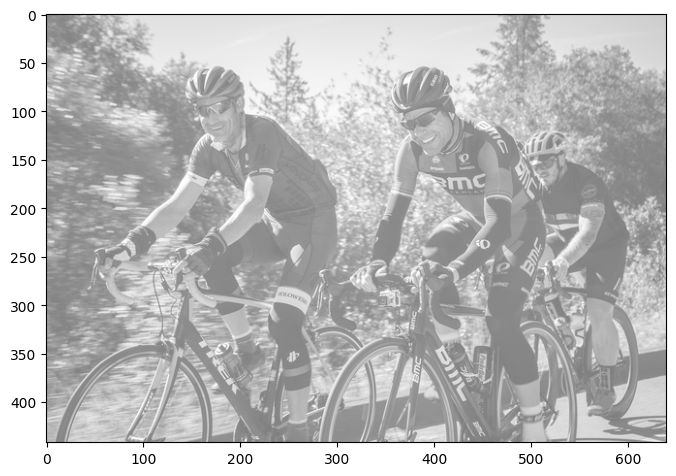

In [11]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)

plt.imshow(img)
model.draw_skeleton(results[0]["x"], alpha=0.8, width=2, node_size=100)

plt.show()

## S_max = 2

In [12]:
max_num_segments = 2
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
    pos=pos,
)

C = B_max

tic = time.perf_counter()
Q, offset = model.build_qubo(C=C, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")

Segmentation and Labeling Problem initialization:
  Number of nodes:  146
  Number of labels:  14
  Maximum number of segments:  2

>>>> QUBO setup: 10.1022 seconds
>>>> BQM setup: 6.9816 seconds


In [13]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  4088
Number of QUBO interactions:  4202096
Matrix sparsity:  0.50301442644019
Energy offset: 15173.78


In [15]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=10_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  10.610905040986836


In [16]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  912.5900000000361
  max:  912.5900000000361
  median:  912.5900000000361
  mean:  912.5900000000361
  std:  0.0
Lowest solution:
  objective:  912.5900000000361
  probability:   1.0
  feasible:   False


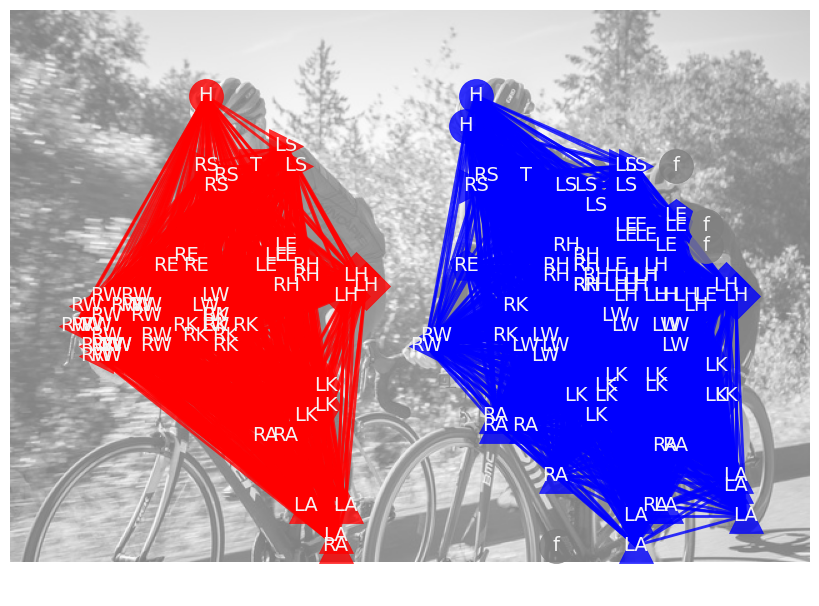

In [17]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)
ax = fig.add_axes(rect=(0, 0, 1, 1), frameon=False)

ax.imshow(img)

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=600,
    width=2,
    alpha=0.8,
)
plt.show()

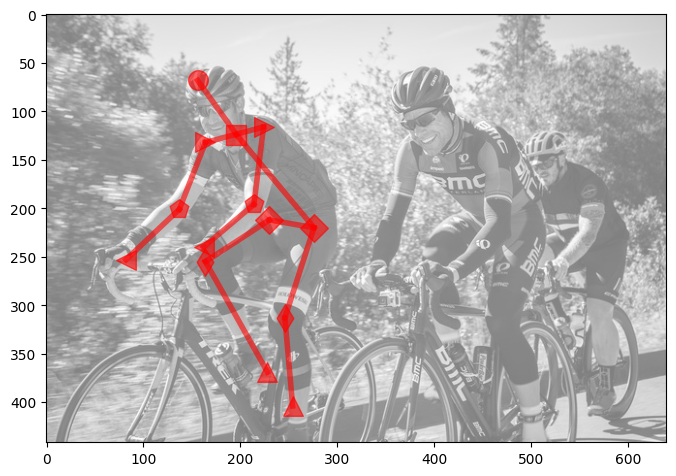

In [18]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)

plt.imshow(img)
model.draw_skeleton(results[0]["x"], alpha=0.8, width=2, node_size=100)

plt.show()

## S_max = 3

In [19]:
max_num_segments = 3
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
    pos=pos,
)

C = B_max

tic = time.perf_counter()
Q, offset = model.build_qubo(C=C, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")

Segmentation and Labeling Problem initialization:
  Number of nodes:  146
  Number of labels:  14
  Maximum number of segments:  3

>>>> QUBO setup: 17.7696 seconds
>>>> BQM setup: 10.3749 seconds


In [20]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  6132
Number of QUBO interactions:  6346068
Matrix sparsity:  0.337599080225258
Energy offset: 15173.78


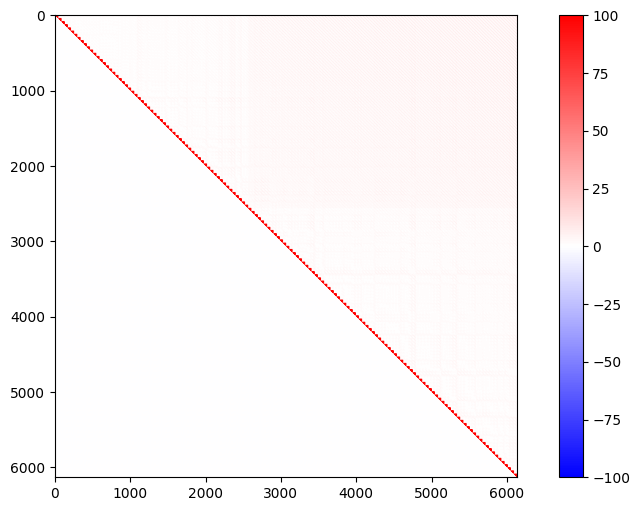

In [21]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [22]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=10_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  11.588836415990954


In [23]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  -2878.0399999999995
  max:  -2878.0399999999995
  median:  -2878.0399999999995
  mean:  -2878.0399999999995
  std:  0.0
Lowest solution:
  objective:  -2878.0399999999995
  probability:   1.0
  feasible:   True


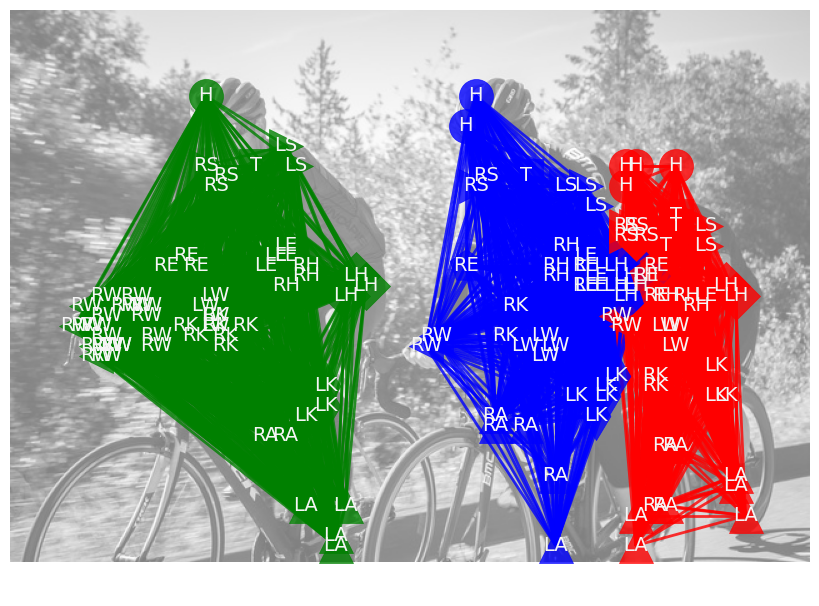

In [24]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)
ax = fig.add_axes(rect=(0, 0, 1, 1), frameon=False)

ax.imshow(img)

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=600,
    width=2,
    alpha=0.8,
)
plt.show()

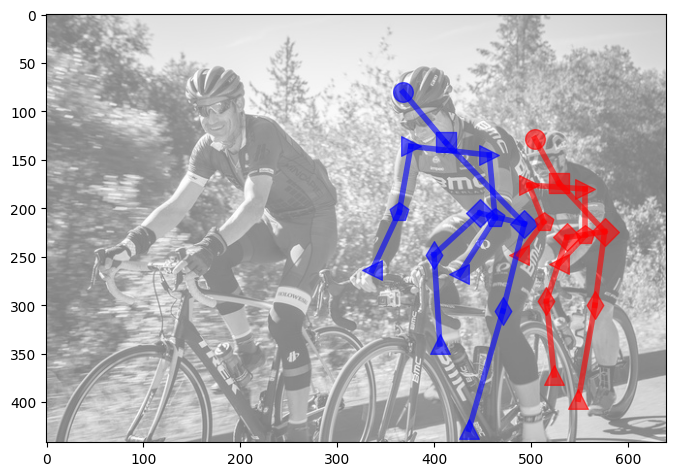

In [25]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)

plt.imshow(img)
model.draw_skeleton(results[0]["x"], alpha=0.8, width=2, node_size=100)

plt.show()

## S_max = 4

In [26]:
max_num_segments = 4
suppress = False

model = SegmentationAndLabeling(
    A=A,
    B=B,
    max_num_segments=max_num_segments,
    class_reindex={v: k for k, v in segLabel.map_DNNclass_reindex.items()},
    suppress=suppress,
    pos=pos,
)

C = B_max

tic = time.perf_counter()
Q, offset = model.build_qubo(C=C, norm=False)
toc = time.perf_counter()
print(f"\n>>>> QUBO setup: {toc - tic:0.4f} seconds")

tic = time.perf_counter()
bqm = BinaryQuadraticModel.from_qubo(Q, offset=offset)
toc = time.perf_counter()
print(f">>>> BQM setup: {toc - tic:0.4f} seconds")

Segmentation and Labeling Problem initialization:
  Number of nodes:  146
  Number of labels:  14
  Maximum number of segments:  4

>>>> QUBO setup: 27.5979 seconds
>>>> BQM setup: 14.4868 seconds


In [27]:
print("Number of QUBO variables: ", bqm.num_variables)
print("Number of QUBO interactions: ", bqm.num_interactions)
print(
    "Matrix sparsity: ",
    bqm.num_interactions / (0.5 * bqm.num_variables * (bqm.num_variables - 1)),
)
print("Energy offset:", bqm.offset)

Number of QUBO variables:  8176
Number of QUBO interactions:  8518656
Matrix sparsity:  0.2549015242643495
Energy offset: 15173.78


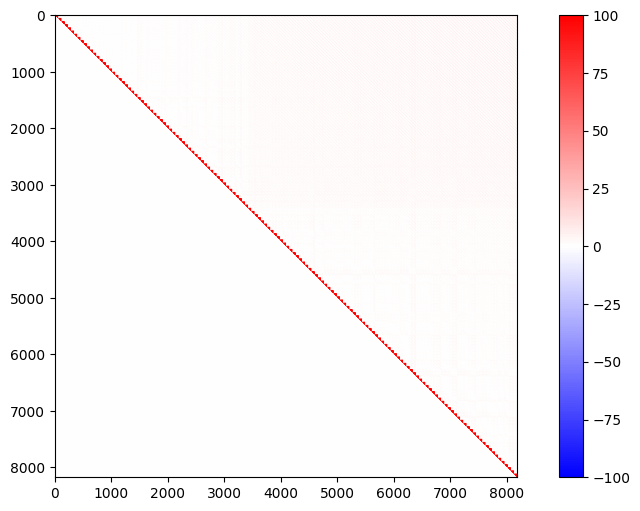

In [28]:
plot_qubo_matrix(Q, vmin=-100, vmax=100)

In [29]:
t0 = time.perf_counter()

sampler = TabuSampler()

n_runs = 1
n_reads = 1

np.random.seed(1234)
seeds = np.random.randint(2**16 - 1, size=n_runs)

sols = Counter(dict())
for _seed in seeds:
    sampleset = sampler.sample(
        bqm,
        num_reads=n_reads,
        seed=_seed,
        timeout=10_000,  # in ms
        num_restarts=1_000_000,
        energy_threshhold=1e-4,
    )
    for data in sampleset.aggregate().data():
        x = list(data.sample.values())
        x_str = "".join([str(int(i)) for i in x])
        sols += Counter({x_str: data.num_occurrences})

sols = dict(sols)

t1 = time.perf_counter()
print("Avg execution time (per run): ", (t1 - t0) / n_runs)

Avg execution time (per run):  14.394627625006251


In [30]:
print("Total number of solutions: ", len(sols))

# extract solution info into dictionary
results = []

for s, p in sols.items():
    x = [int(i) for i in s]
    obj = bqm.energy(x)
    results.append(
        {
            "x": x,
            "obj": obj,
            "prob": p / (n_reads * n_runs),
            "feas": model.is_valid(x),
        }
    )

results = sorted(results, key=lambda k: k["obj"])

obj = [s["obj"] for s in results]
print(f"Objective:")
print(f"  min: ", np.min(obj))
print(f"  max: ", np.max(obj))
print(f"  median: ", np.median(obj))
print(f"  mean: ", np.mean(obj))
print(f"  std: ", np.std(obj))

print("Lowest solution:")
print(f"  objective: ", results[0]["obj"])
print(f"  probability:  ", results[0]["prob"])
print(f"  feasible:  ", results[0]["feas"])

Total number of solutions:  1
Objective:
  min:  -3893.8099999999813
  max:  -3893.8099999999813
  median:  -3893.8099999999813
  mean:  -3893.8099999999813
  std:  0.0
Lowest solution:
  objective:  -3893.8099999999813
  probability:   1.0
  feasible:   True


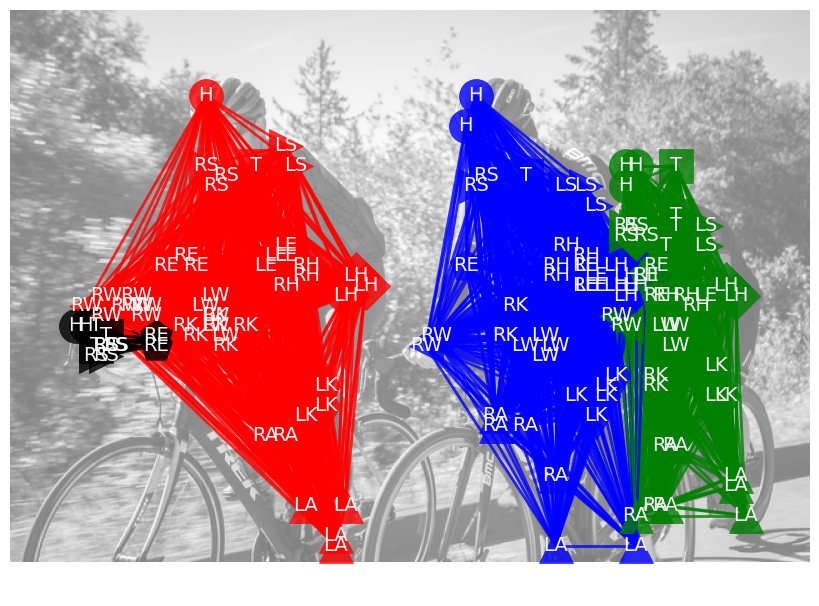

In [31]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)
ax = fig.add_axes(rect=(0, 0, 1, 1), frameon=False)

ax.imshow(img)

model.draw_solution(
    ax,
    results[0]["x"],
    node_size=600,
    width=2,
    alpha=0.8,
)
plt.show()

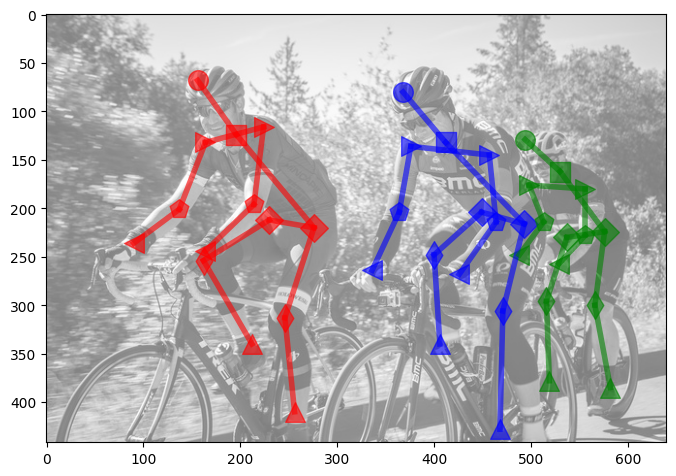

In [32]:
# draw the lowest energy solution
fig = plt.figure(figsize=(8, 6), frameon=False)

plt.imshow(img)
model.draw_skeleton(results[0]["x"], alpha=0.8, width=2, node_size=100)

plt.show()